We just did our analysis on brand.
Can we find some patterns regarding the products aswell?

In [2]:
import warnings
warnings.filterwarnings("ignore")

# loading packages
# basic + dates 
import numpy as np
import pandas as pd
from pandas import datetime

In [3]:
# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline

In [4]:
# statistics
from statsmodels.distributions.empirical_distribution import ECDF

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# prophet by Facebook
from fbprophet import Prophet

In [5]:
# importing train data to learn
train = pd.read_csv("god.csv", 
                    parse_dates = True, low_memory = False, index_col = 'date')
# time series as indexes
train.index
train = train.drop(columns="Unnamed: 0")

In [6]:
# data extraction
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

# adding new variable
train['sale_per_customer'] = train['sales']/train['customers']

In [7]:
# fill NaN with a 0 for competitor ID
train["competitor_id"].fillna(0, inplace=True)

In [8]:
train.groupby('product')['sales'].describe()

,count,mean,std,min,25%,50%,75%,max
product,,,,,,,,
a,397466.0,5483.730925,3708.653603,0.0,3471.0,5444.0,7515.0,38025.0
b,6169.0,8342.894634,3853.630562,0.0,5297.0,7769.0,10926.0,22137.0
c,350364.0,6022.541993,3994.487054,0.0,3965.0,5978.0,8124.0,38037.0


We have a far greater proportion of product A and C compared to product B. Product B revenue on average is higher than product A and B but has a lower maximum value.

In [9]:
train.groupby('product')['customers', 'sales'].sum()

,customers,sales
product,,
a,248416848,2179596596
b,12438829,51467317
c,219655279,2110081903


As highlighted before, we have a far lower proportion of revenue regarding product B compared to A and C.

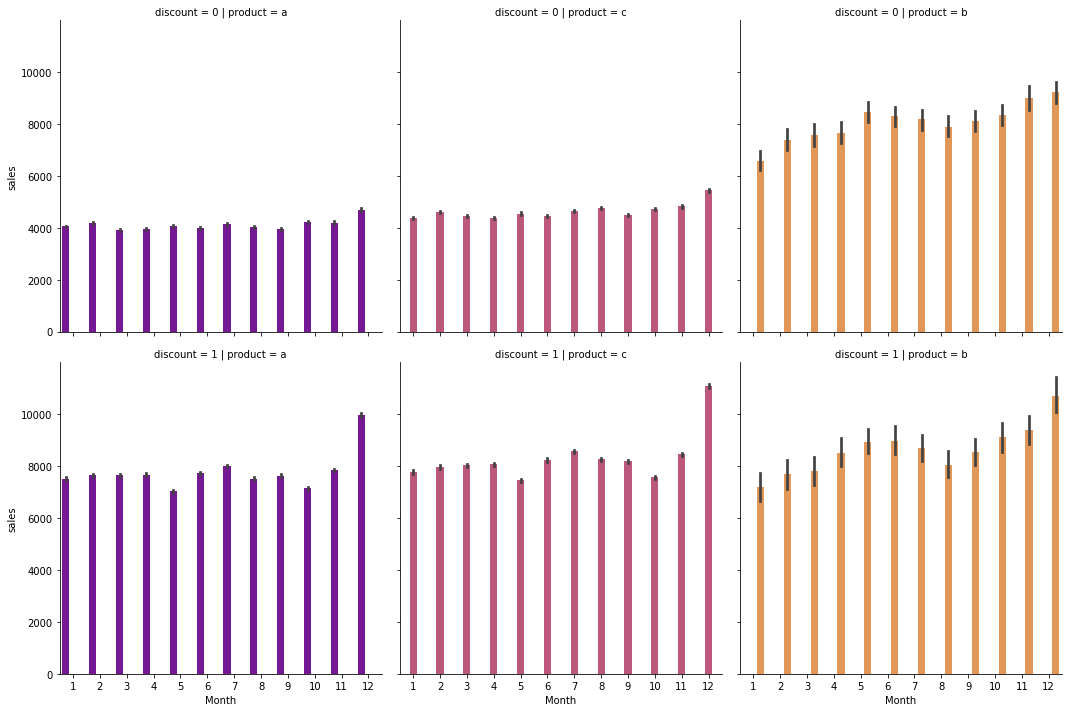

In [9]:
# sales trends
sns.catplot(data = train, x = 'Month', y = "sales", 
               col = 'product',
               palette = 'plasma',
               hue = 'product',
               row = 'discount',
            kind="bar") 

As highlighted in the previous notebook, the revenue is much higher in December compared to the other months of the year. We can also see that discount greatly influence the number of sales regardless of the month.

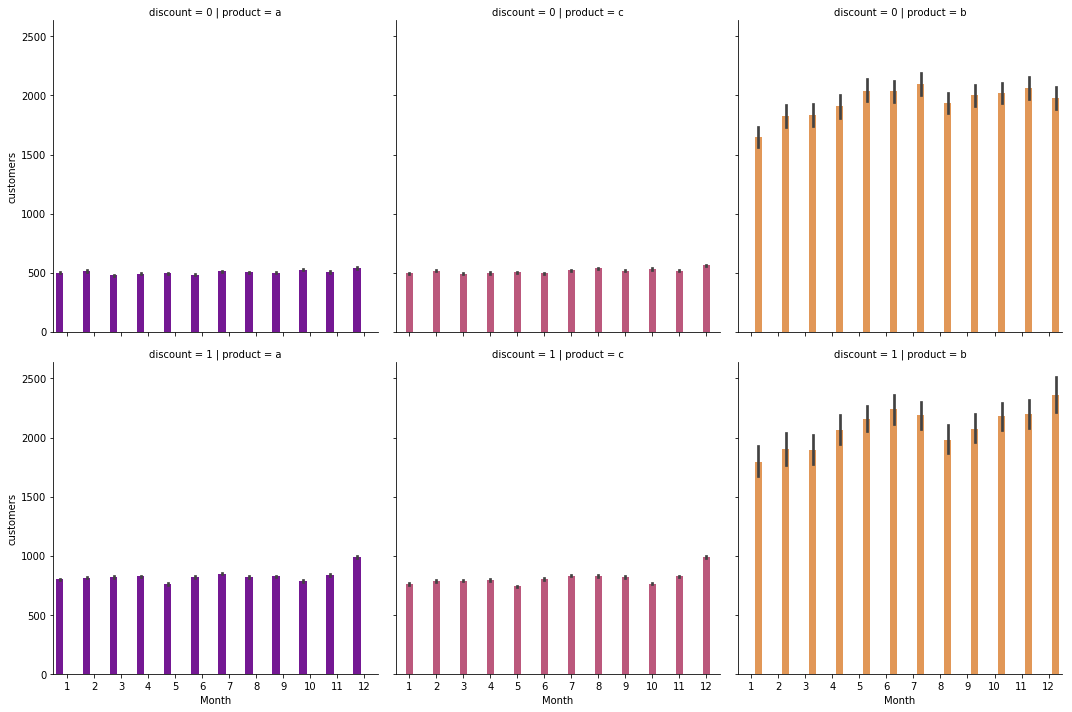

In [10]:
# sales trends
sns.catplot(data = train, x = 'Month', y = "customers", 
               col = 'product',
               palette = 'plasma',
               hue = 'product',
               row = 'discount',
            kind="bar")

We can see here that product A and C does not have a large number of customer compared to the revenue we saw before, we shall confirm this assumption by looking at the number of sales per customer.

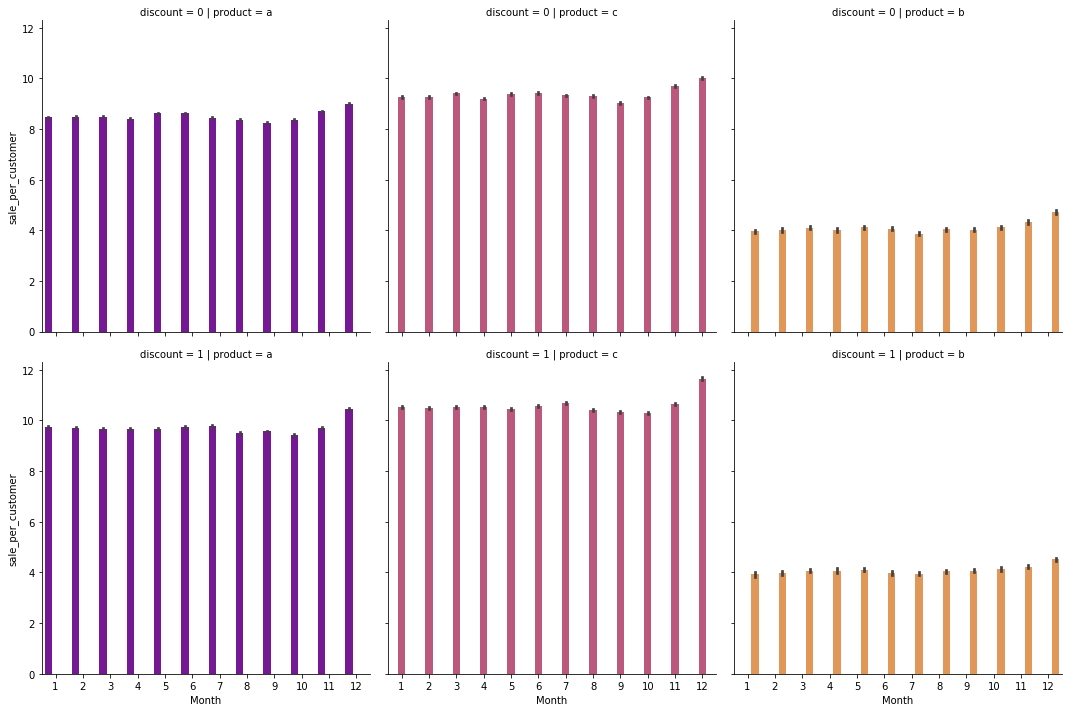

In [12]:
# sales trends
sns.catplot(data = train, x = 'Month', y = "sale_per_customer", 
               col = 'product',
               palette = 'plasma',
               hue = 'product',
               row = 'discount',
            kind="bar") 

Sale (aka revenue) per customer confirms our previous assumption, products A and C are the most expensive, product B is thus the least expensive item.

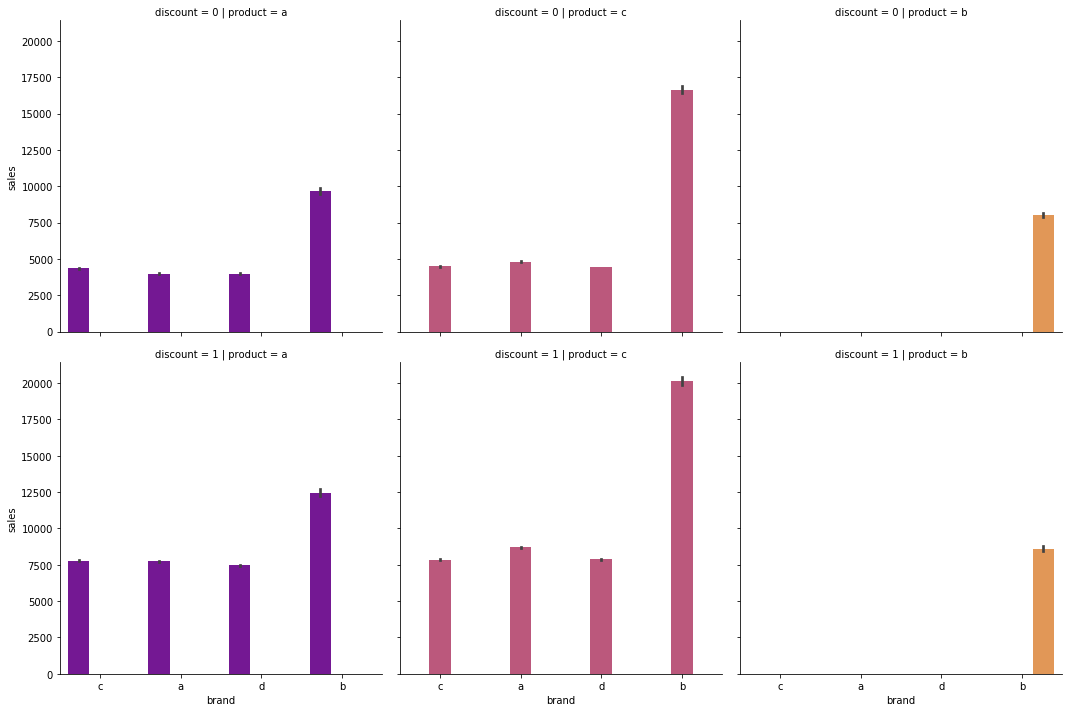

In [11]:
# sales trends
sns.catplot(data = train, x = 'brand', y = "sales", 
               col = 'product',
               palette = 'plasma',
               hue = 'product',
               row = 'discount',
            kind="bar") 

So what about brands?
<br>
<br>
We know from our previous analysis that brand A and D are the most successful, and brand B the one with the least customer but still decent revenue.
<br>
<br>
Interestingly enough, brand B is the one with the larger product mix (A+B+C) and is the only one to sell B product. The product category mix is skewed towards the product category C. Product category A follows then B.
The other brands have a product category mix balanced between A and B.
<br>
<br>
We finally notice that the discount has no effect on product B whereas for product A and C it greatly increases the sales.



In [13]:
train.groupby('product')['sale_per_customer'].describe()

,count,mean,std,min,25%,50%,75%,max
product,,,,,,,,
a,340938.0,9.043425,1.957290,0.000000,7.599141,8.758539,10.260524,57.614983
b,6302.0,4.109316,0.619667,0.000000,3.665684,4.022791,4.469783,7.367793
c,301071.0,9.910013,2.186814,4.151235,8.278175,9.712036,11.335945,64.957854


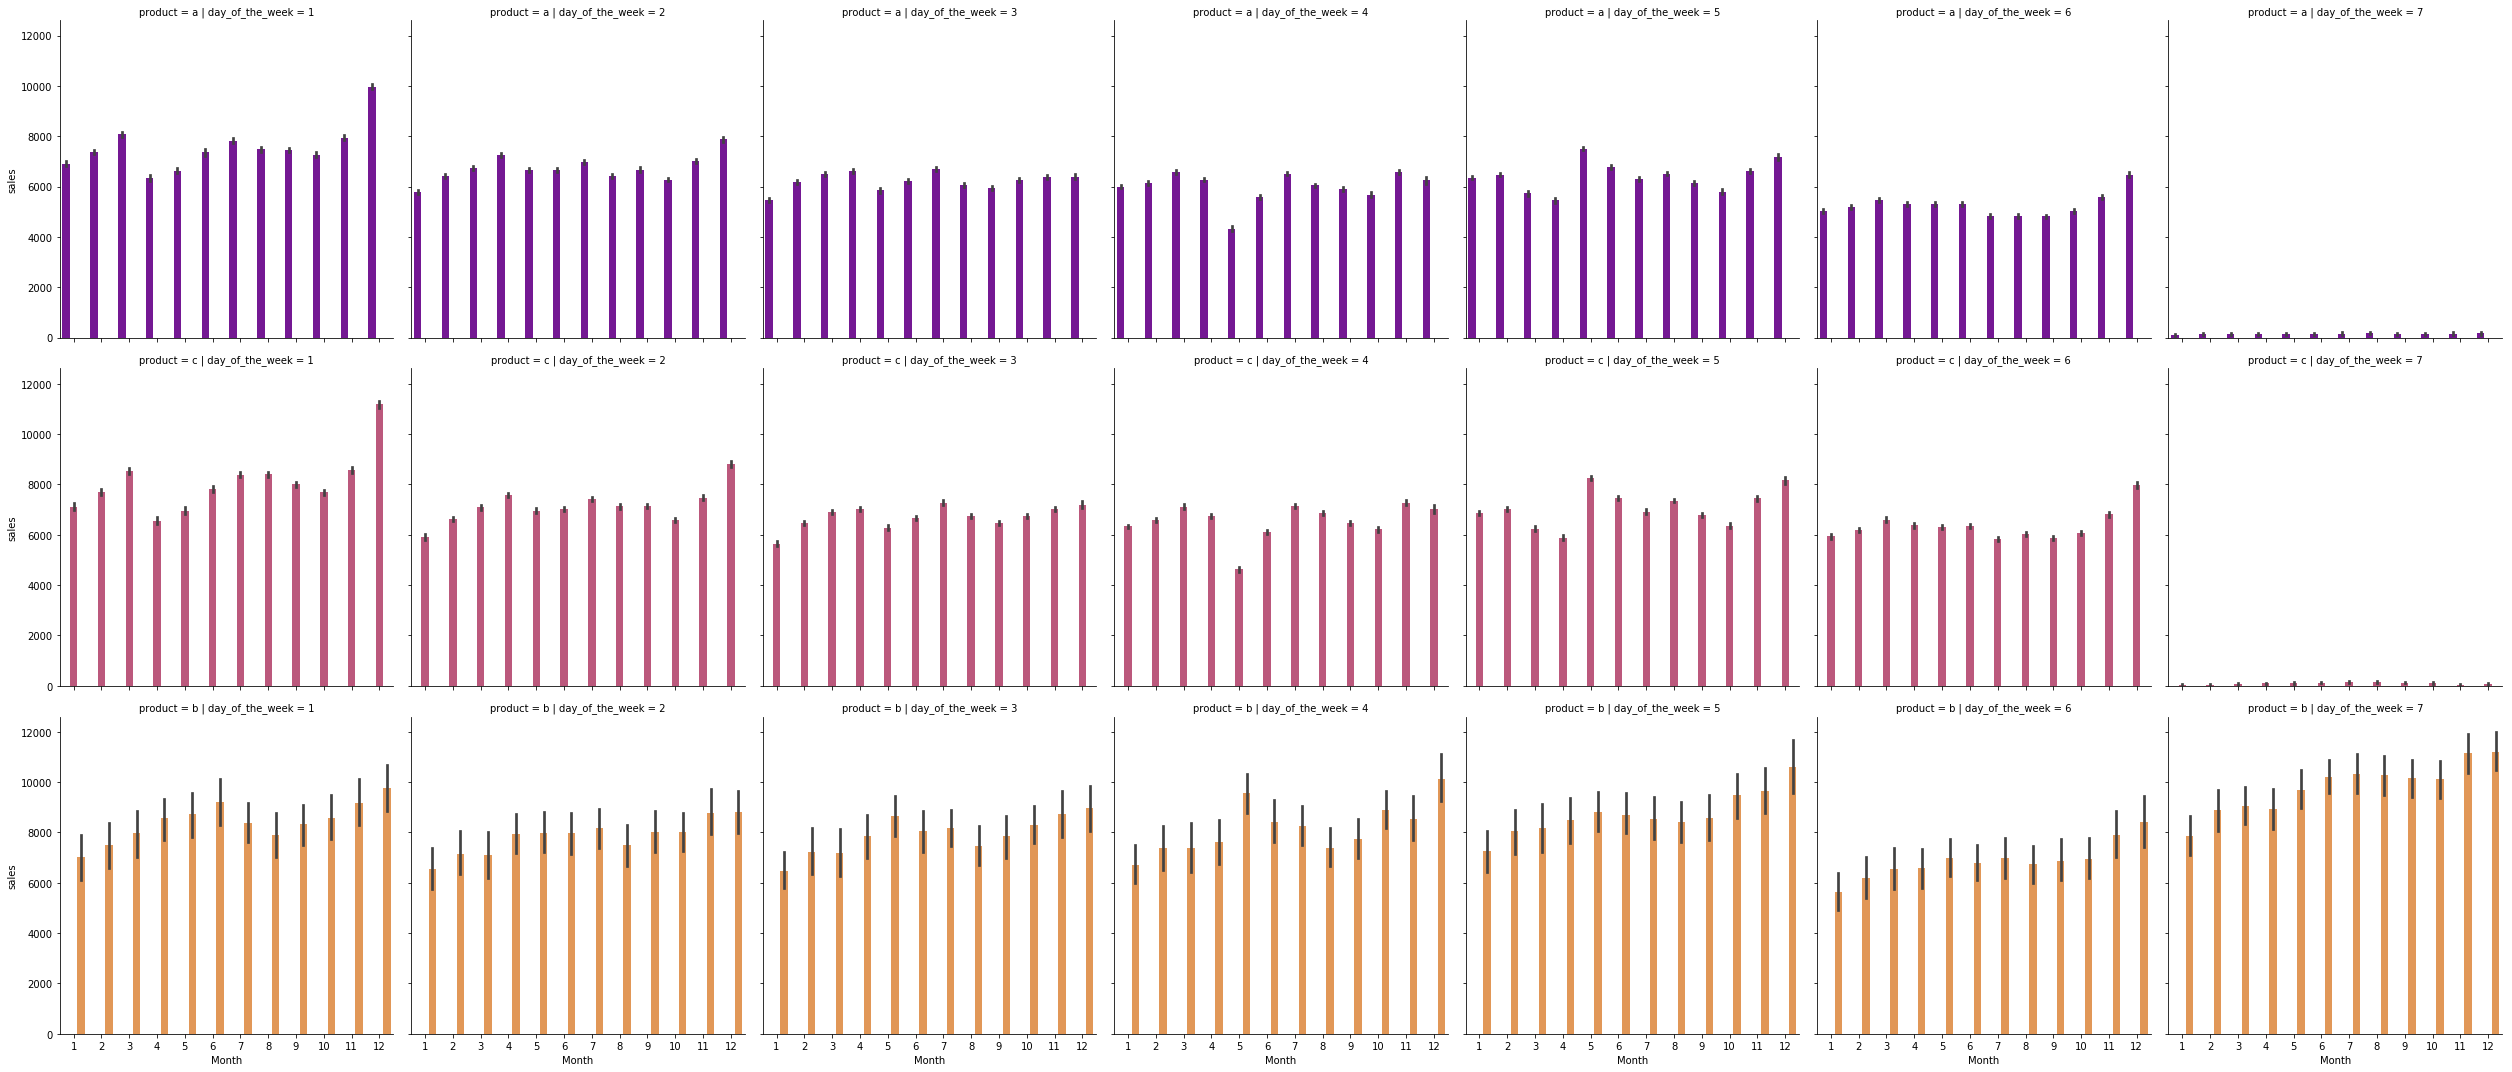

In [14]:
sns.catplot(data = train, x = 'Month', y = "sales", 
               col = "day_of_the_week",
               palette = 'plasma',
               hue = 'product',
               row = 'product',
            kind="bar")

When looking at the revenue repartition for product category per day, we can see that it follows the same pattern as the brands which make sense.

In [15]:
# competition open time (in months)
train['comp_time'] = 12 * (train.Year - train.year_comp1) + \
        (train.Month - train.month_comp1)

In [16]:
# average CompetitionOpen time per product type
train.loc[:, ['brand','product', 'sales', 'customers', 'comp_time']].groupby('product').mean()

,sales,customers,comp_time
product,,,
a,5475.769319,624.273357,6372.876953
b,8252.842781,1998.515033,15922.902756
c,6000.444703,625.008778,9113.213248


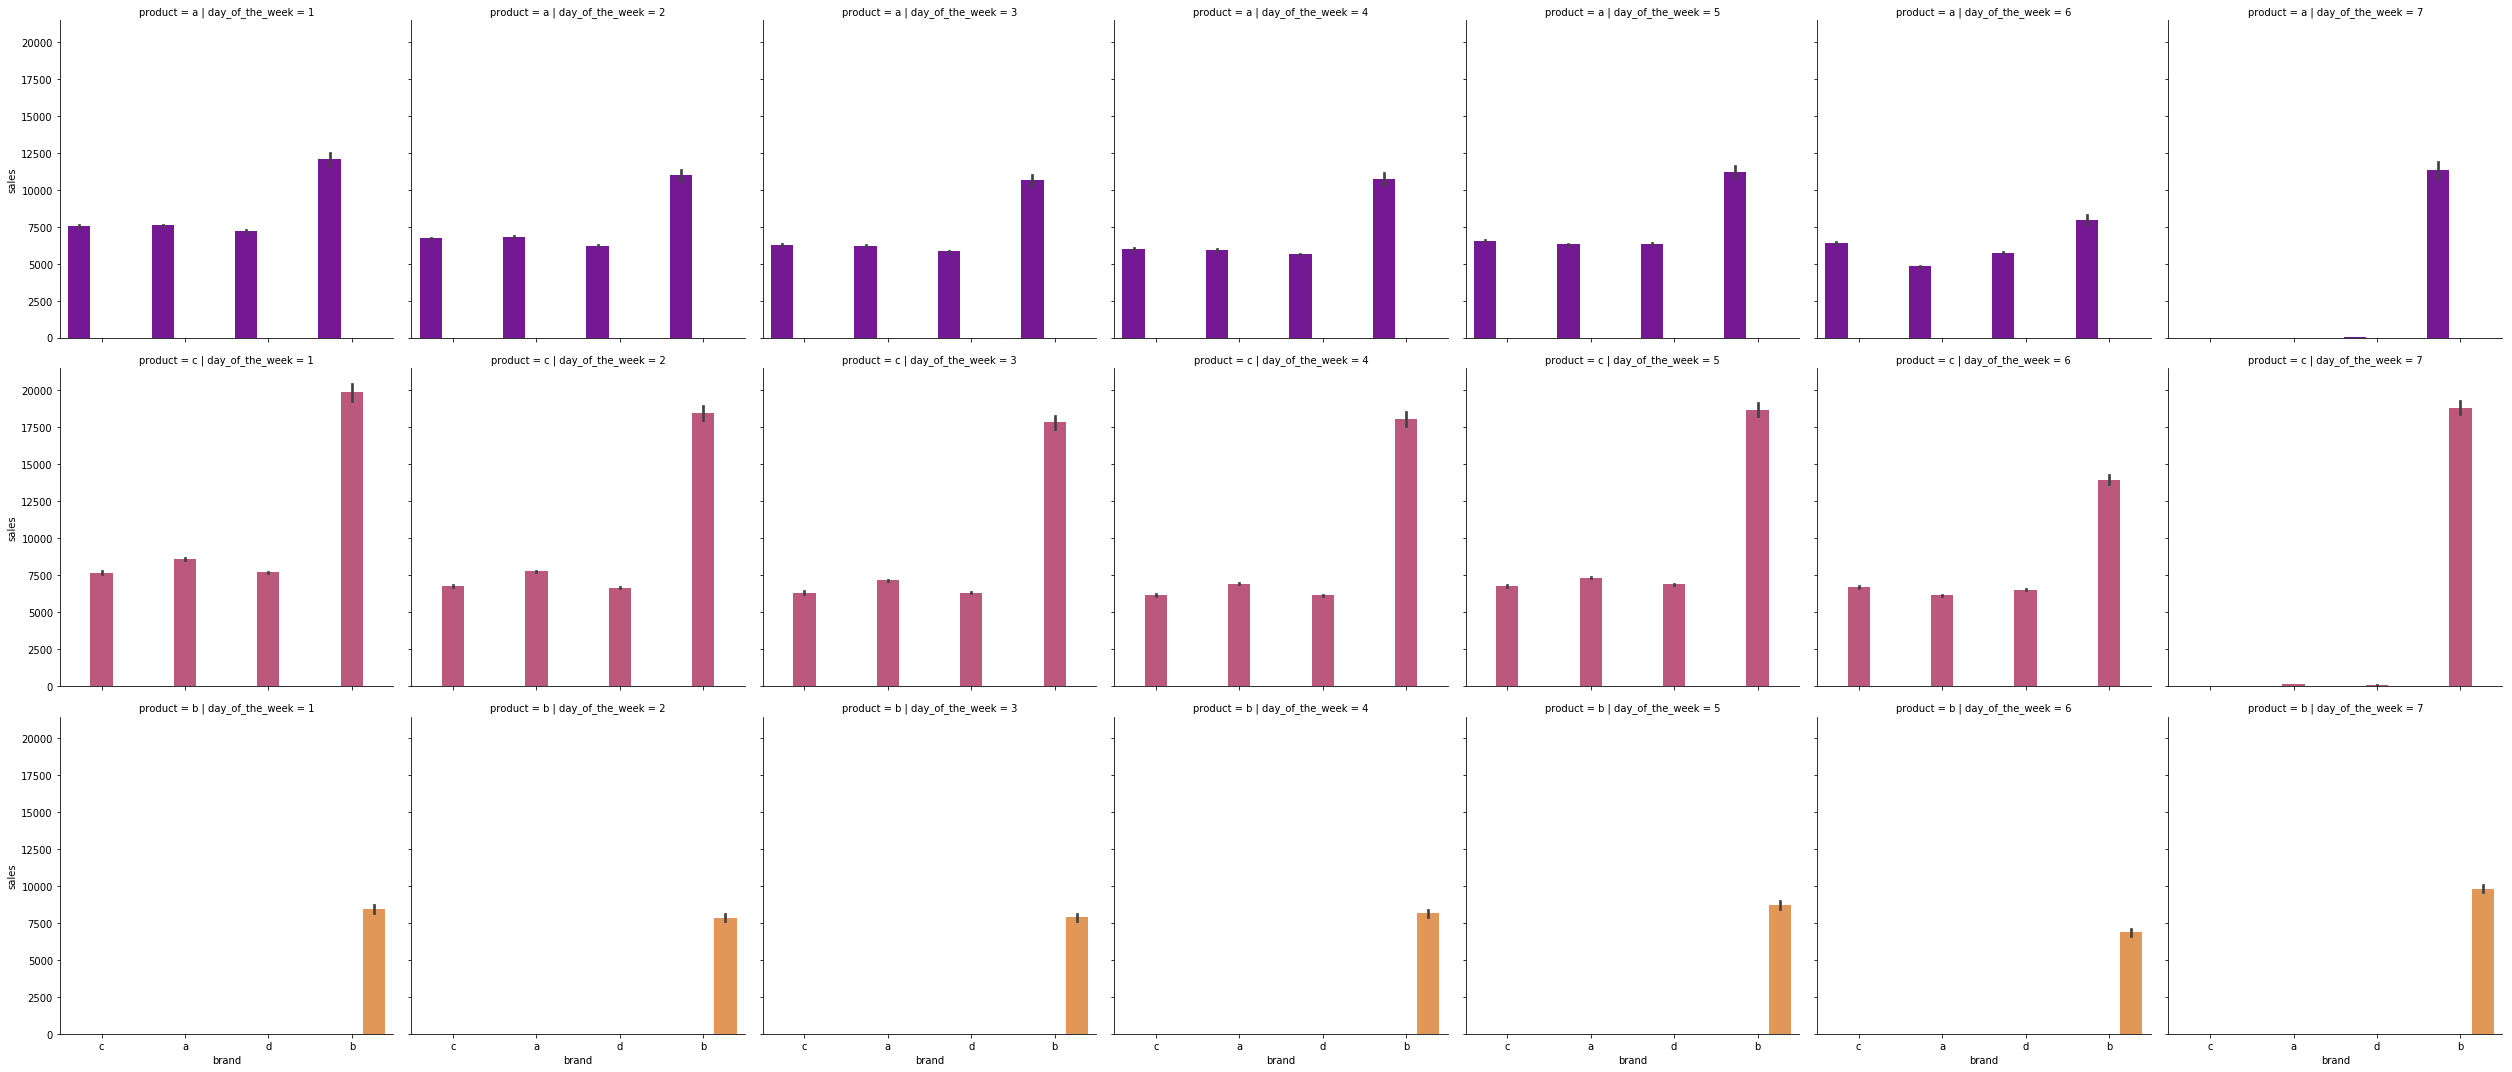

In [17]:
sns.catplot(data = train, x = 'brand', y = "sales", 
               col = "day_of_the_week",
               palette = 'plasma',
               hue = 'product',
               row = 'product',
            kind="bar")

This plot confirms the previous product mix from brands by showing that almost only brand B sells during on Sunday.

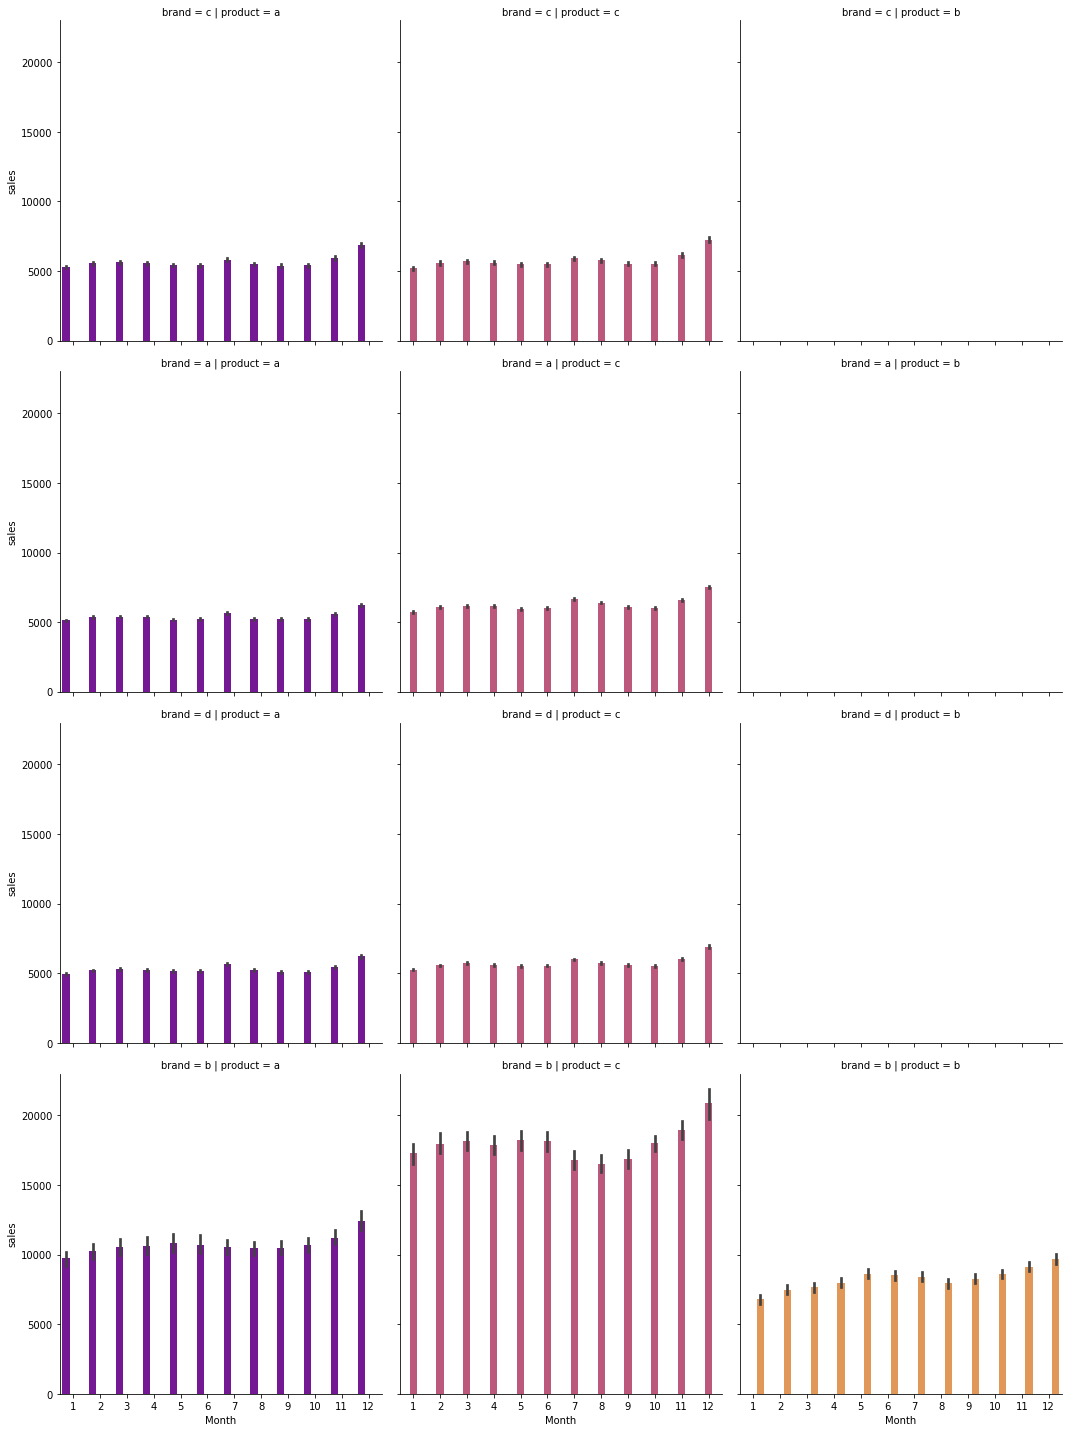

In [18]:
# sales trends
sns.catplot(data = train, x = 'Month', y = "sales", 
               col = 'product',
               palette = 'plasma',
               hue = 'product',
               row = 'brand',
            kind="bar") 

We have the same seasonlality around christmas as the brands.

<h2>Time Series</h2>

In [19]:
# preparation: input should be float type
train['sales'] = train['sales'] * 1.0

In [20]:
import pandas as pd
sales_a = train[train['product']=="a"]['sales']
sales_b = train[train['product']=="b"]['sales']
sales_c = train[train['product']=="c"]['sales']

# products
sales_a = sales_a.resample('W').sum()
sales_b = sales_b.resample('W').sum()
sales_c = sales_c.resample('W').sum()

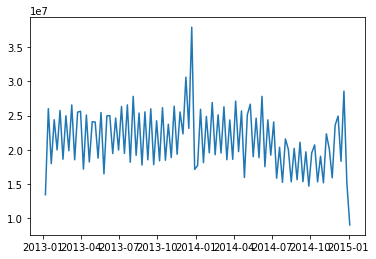

In [21]:
plt.plot(sales_a.index, sales_a.values)

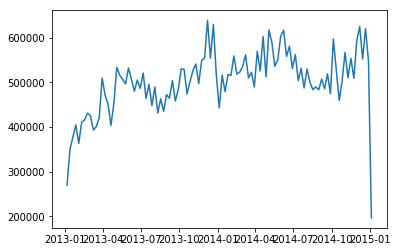

In [22]:
plt.plot(sales_b.index, sales_b.values)

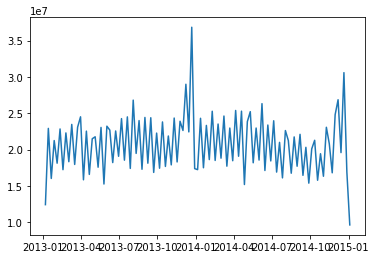

In [23]:
plt.plot(sales_c.index, sales_c.values)

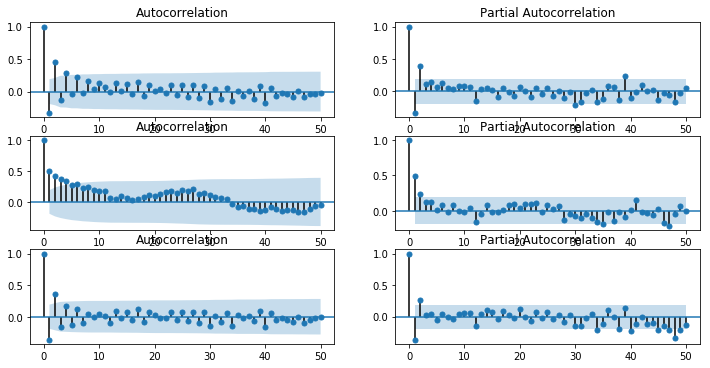

In [24]:
# figure for subplots
plt.figure(figsize = (12, 8))

# acf and pacf for A
plt.subplot(421); plot_acf(sales_a, lags = 50, ax = plt.gca())
plt.subplot(422); plot_pacf(sales_a, lags = 50, ax = plt.gca())

# acf and pacf for B
plt.subplot(423); plot_acf(sales_b, lags = 50, ax = plt.gca())
plt.subplot(424); plot_pacf(sales_b, lags = 50, ax = plt.gca())

# acf and pacf for C
plt.subplot(425); plot_acf(sales_c, lags = 50, ax = plt.gca())
plt.subplot(426); plot_pacf(sales_c, lags = 50, ax = plt.gca())

plt.show()

Here we can see that the product category A and C follow an autocorrelated pattern with points correlating with eachother. Product B however sells well at the start and decrease all the way during the timelag.

<h2>Forecast</h2>

In [25]:
# importing data
df = pd.read_csv("god.csv",  
                    low_memory = False)

# remove closed stores and those with no sales
df = df[(df["store_status"] != 0) & (df['sales'] != 0)]

# sales for the store products
salesa = df[df['product']=="a"].loc[:, ['date', 'sales']]
salesb = df[df['product']=="b"].loc[:, ['date', 'sales']]
salesc = df[df['product']=="c"].loc[:, ['date', 'sales']]

# reverse to the order: from 2013 to 2015
salesa = salesa.sort_index(ascending = False)
salesb = salesb.sort_index(ascending = False)
salesc = salesc.sort_index(ascending = False)

# to datetime64
salesa['date'] = pd.DatetimeIndex(salesa['date'])
salesb['date'] = pd.DatetimeIndex(salesb['date'])
salesc['date'] = pd.DatetimeIndex(salesc['date'])

In [26]:
# from the prophet documentation every variables should have specific names
salesa = salesa.rename(columns = {'date': 'ds',
                                'sales': 'y'})
salesb = salesb.rename(columns = {'date': 'ds',
                                'sales': 'y'})
salesc = salesc.rename(columns = {'date': 'ds',
                                'sales': 'y'})

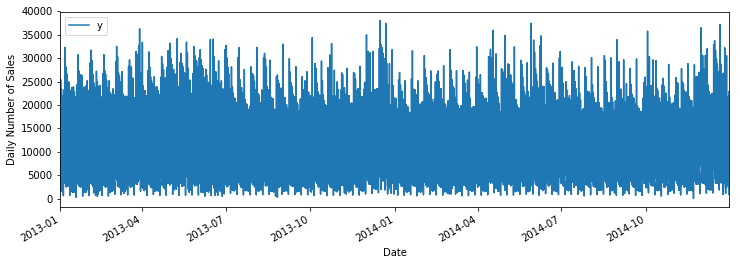

In [27]:
# plot daily sales
ax = salesa.set_index('ds').plot(figsize = (12, 4))
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

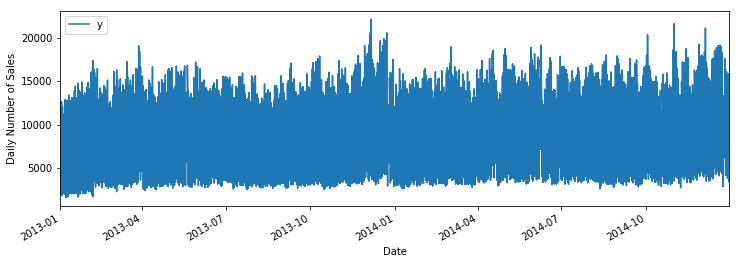

In [28]:
# plot daily sales
ax = salesb.set_index('ds').plot(figsize = (12, 4))
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

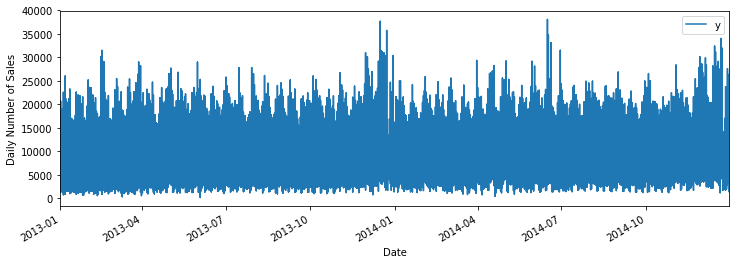

In [29]:
# plot daily sales
ax = salesc.set_index('ds').plot(figsize = (12, 4))
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

In [30]:
# create holidays dataframe
state_dates = df[(df.holiday == 'a') | (df.holiday == 'b') & (df.holiday == 'c')].loc[:, 'date'].values
competitor_open = df[df.competitor == 1].loc[:, 'date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
competitor = pd.DataFrame({'holiday': 'competitor_holiday',
                      'ds': pd.to_datetime(competitor_open)})

holidays = pd.concat((state, competitor))      
holidays.head()

,holiday,ds
0,state_holiday,2014-11-01
1,state_holiday,2014-11-01
2,state_holiday,2014-11-01
3,state_holiday,2014-11-01
4,state_holiday,2014-11-01


In [31]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_modela = Prophet(interval_width = 0.95, 
                   holidays = holidays, weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
my_modela.fit(salesa)

my_modelb = Prophet(interval_width = 0.95, 
                   holidays = holidays, weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
my_modelb.fit(salesb)

my_modelc = Prophet(interval_width = 0.95, 
                   holidays = holidays, weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
my_modelc.fit(salesc)

# dataframe that extends into future 6 weeks 
future_datesa = my_modela.make_future_dataframe(periods = 52*7)
future_datesb = my_modelb.make_future_dataframe(periods = 52*7)
future_datesc = my_modelc.make_future_dataframe(periods = 52*7)

In [32]:
# predictions
forecasta = my_modela.predict(future_datesa)
forecastb = my_modelb.predict(future_datesb)
forecastc = my_modelc.predict(future_datesc)

In [33]:
fca = forecasta[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})
fcb = forecastb[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})
fcc = forecastc[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})

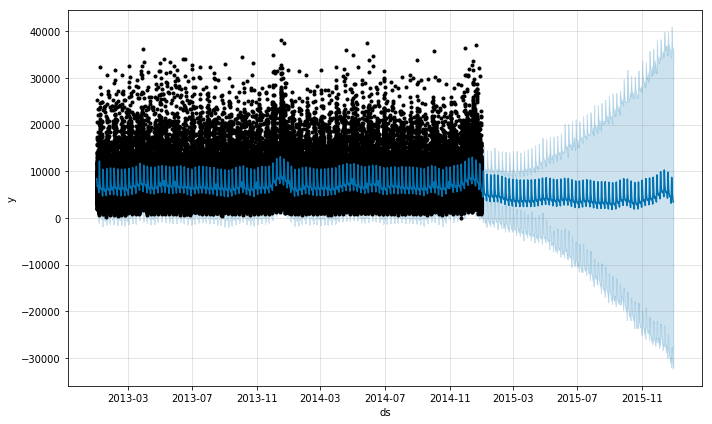

In [34]:
# visualizing predicions
my_modela.plot(forecasta);

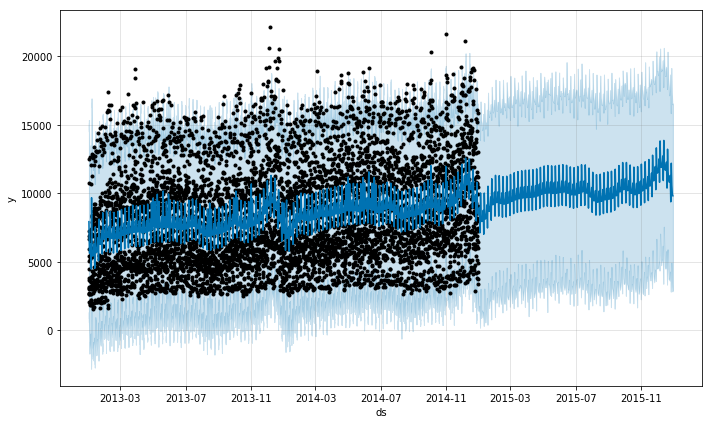

In [35]:
# visualizing predicions
my_modelb.plot(forecastb);

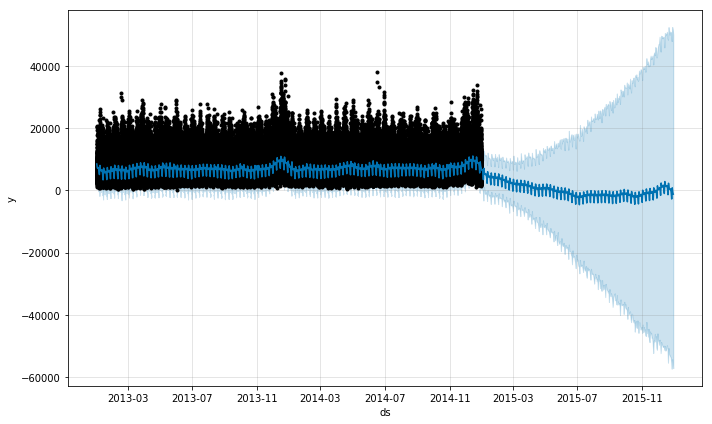

In [36]:
# visualizing predicions
my_modelc.plot(forecastc);

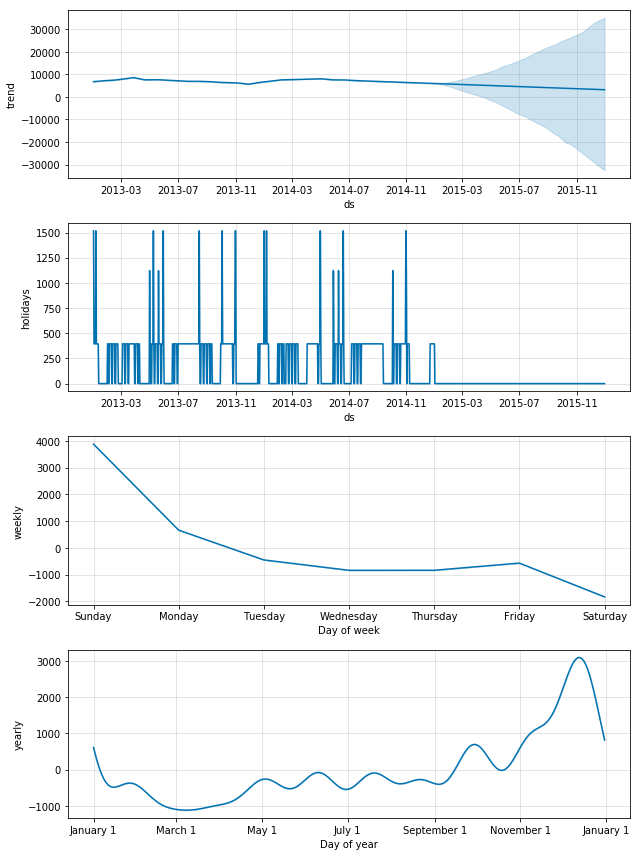

In [37]:
my_modela.plot_components(forecasta);

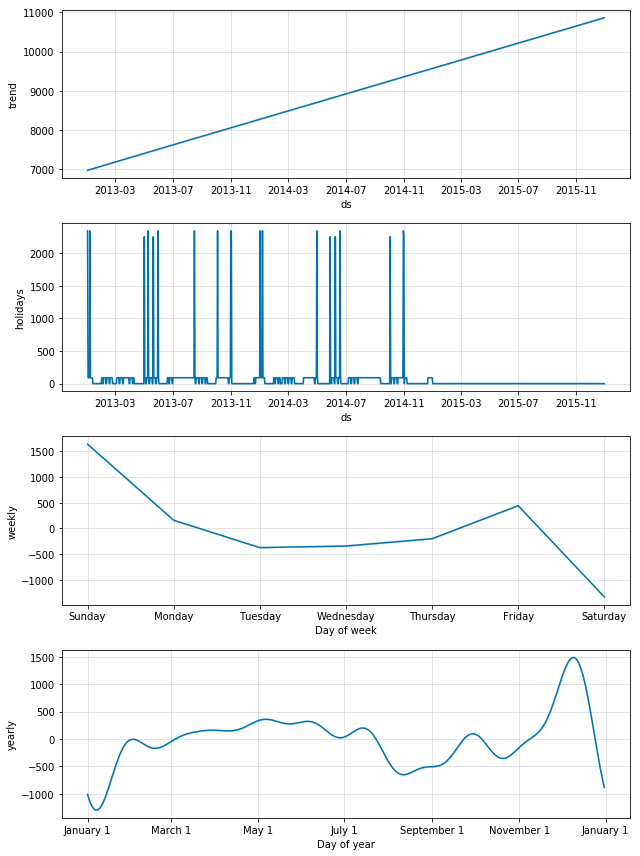

In [38]:
my_modelb.plot_components(forecastb);

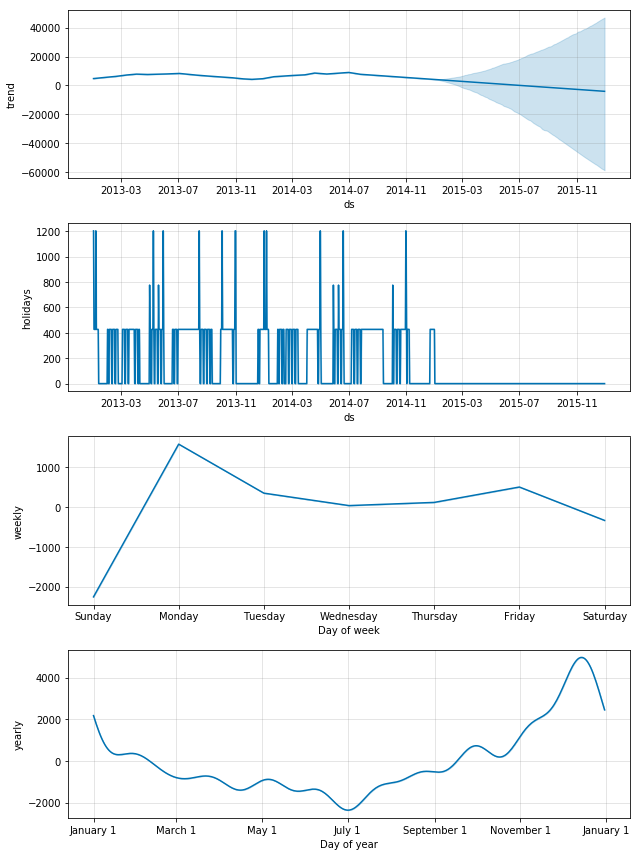

In [39]:
my_modelc.plot_components(forecastc);